In [1]:
%%bash
wget http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_distractor_v1.json

--2025-06-20 06:17:20--  http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_distractor_v1.json
Resolving curtis.ml.cmu.edu (curtis.ml.cmu.edu)... 128.2.204.193
Connecting to curtis.ml.cmu.edu (curtis.ml.cmu.edu)|128.2.204.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46320117 (44M) [application/json]
Saving to: ‘hotpot_dev_distractor_v1.json’

     0K .......... .......... .......... .......... ..........  0%  275K 2m44s
    50K .......... .......... .......... .......... ..........  0%  549K 2m3s
   100K .......... .......... .......... .......... ..........  0%  123M 82s
   150K .......... .......... .......... .......... ..........  0% 52.9M 62s
   200K .......... .......... .......... .......... ..........  0%  554K 66s
   250K .......... .......... .......... .......... ..........  0%  139M 55s
   300K .......... .......... .......... .......... ..........  0% 81.8M 47s
   350K .......... .......... .......... .......... ..........  0%  113M 41s
   

In [2]:
import pandas as pd

json_path='/kaggle/working/hotpot_dev_distractor_v1.json'

df=pd.read_json(json_path)
df.shape

(7405, 7)

In [3]:
# Shuffle the DataFrame and reset the index
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select the first 1000 rows
df_shuffled = df_shuffled.head(1300)
df_shuffled.shape

(1300, 7)

In [4]:
first=df_shuffled.iloc[0]
print(first['context'])
print(first.supporting_facts)

[['Constantin Medien', ['Constantin Medien AG (formerly EM.Entertainment and EM.TV & Merchandising AG, then EM.TV AG, and finally em.sport media ag) is a German media group, based in Ismaning near Munich, active in the area of sports, film and event marketing to medium-sized media companies.']], ['VIVA Poland', ['VIVA Polska (earlier "VIVApolska!")', ' is a Polish 24h music and entertainment channel from Viacom International Media Networks Polska.', ' The channel was officially launched on June 10, 2000 by the German VIVA Media AG.']], ['Viva (UK and Ireland)', ['Viva (stylised as VIVA) is a music television channel in the United Kingdom and Ireland, owned by VIVA Media and thereby Viacom International Media Networks Europe.', ' The channel launched on 26 October 2009, replacing TMF.']], ['Blic', ['Blic (Cyrillic: Блиц, ] ) is a daily middle-market tabloid newspaper in Serbia.', ' Founded in 1996, "Blic" is owned by Ringier Axel Springer Media AG, a joint venture between Ringier media 

# Context is We Need

In [5]:
def extract_contexts(supporting_facts, context_list):
    """
    supporting_facts: list of [entity_name, sent_idx], e.g. [['VIVA Media', 0], ...]
    context_list: list of [entity_name, [sent1, sent2, ...]], e.g. [['VIVA Media', [...]], ...]
    Returns: list of matched context sentences
    """
    evidence = []
    # Build a dict for fast lookup
    context_dict = {entity: sents for entity, sents in context_list}
    for entity, sent_idx in supporting_facts:
        if entity in context_dict:
            sents = context_dict[entity]
            if 0 <= sent_idx < len(sents):
                evidence.append(sents[sent_idx])
    return evidence

# Apply the function to the DataFrame
df_shuffled['evidence'] = df_shuffled.apply(
    lambda row: extract_contexts(row['supporting_facts'], row['context']),
    axis=1
)

df_shuffled['evidence'] = df_shuffled['evidence'].apply(lambda x: ' '.join(x) if x is not None else '')

df_shuffled.shape

(1300, 8)

In [6]:
from typing import Optional, List, Tuple, Dict, Union
from pydantic import BaseModel, Field

class Entity(BaseModel):
    _id: str
    answer: str
    question: str
    supporting_facts: List[Tuple[str,int]]
    context: List[Tuple[str,List[str]]]
    question_type: str = Field(..., alias='type')  # Renaming 'type' to 'question_type'
    level: str
    evidence: str

class ReasoningPath(BaseModel):
    question: str
    context: str
    reason: str
    answer: Optional[str]=None
    ground_truth: str
    temperature: float
    tokens: int
    score: float

entities = [Entity.model_validate(row) for row in df_shuffled.to_dict(orient='records')]
print(len(entities))

1300


In [7]:
import re

from sketch_of_thought import SoT
from doraemon import Doraemon
from relaxed_fda import RelaxedFDA

logger=Doraemon.get_logger(name=__name__, logfile="hotpot_qa_dataset_builder.log")


def process_entity(args)-> Optional[ReasoningPath]:
    
    et,paradigm,temperature=args
    
    try:
        prompt=SoT.few_short_support(
            task_name='HOTPOTQA', 
            prompt=SoT.get_initialized_prompt(paradigm=paradigm),
            few_short=SoT.get_few_short(task_name='HOTPOTQA'),
            question=f"Question:{et.question}\nContext:{et.evidence}"
        )
        r_s, tokens=Doraemon.inference(logger=logger, messages=prompt, temperature=temperature)
        result=ReasoningPath(
            question=str(et.question), 
            context=et.evidence,
            reason=str(r_s), 
            answer=RelaxedFDA.get_answer(r_s),
            ground_truth=str(et.answer),
            temperature=float(temperature), 
            tokens=int(tokens), 
            score=0.0)
        return result
    except Exception as e:
        logger.error(f"Error processing quetion {et.question} at temperature {temperature} with exception {e}")
        return None


paradigm = SoT.classify_question(entities[0].question)
logger.info(paradigm)
assert "conceptual_chaining"==str(paradigm)

2025-06-20 06:17:44.439571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750400264.666233      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750400264.731168      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

2025-06-20 06:18:08,165 INFO conceptual_chaining


In [8]:
temperatures = [i * 0.25 for i in range(9)]  # [0.0, 0.25, 0.5, ... ,2.0]

tasks=[]
for et in entities:
    for tp in temperatures:
        tasks.append((et,paradigm,tp))
logger.info(len(tasks))

2025-06-20 06:18:08,190 INFO 11700


In [9]:
from tqdm import tqdm
import concurrent.futures

with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
    results=list(tqdm(executor.map(process_entity, tasks), total=len(tasks)))

100%|██████████| 11700/11700 [5:18:49<00:00,  1.63s/it]


In [10]:
final_list:List[Dict] = [rp.model_dump() for rp in results if rp is not None]

final_df=pd.DataFrame(final_list)
final_df.to_pickle('sots_df.pkl')

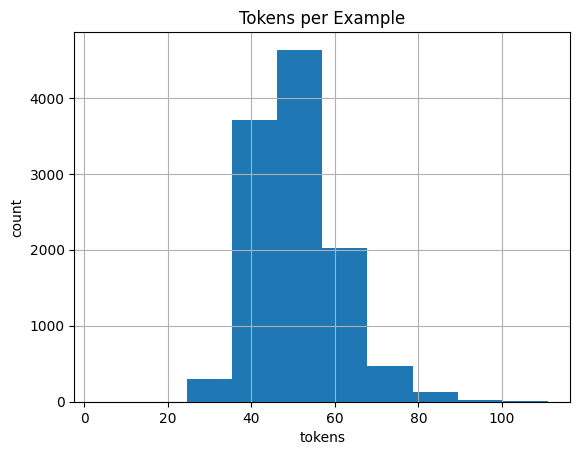

In [11]:
import matplotlib.pyplot as plt

# Tokens distribution
plt.figure()
final_df['tokens'].hist()
plt.title("Tokens per Example")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()

In [12]:
!rm -rf /kaggle/working/hotpot_dev_distractor_v1.json